In [1]:
import os
import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

%matplotlib inline
plt.style.use('default')

In [2]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 3600
TARGET_NAME = 'final_price'
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [3]:
train_df = pd.read_csv('data/train_data.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    34999 non-null  object 
 2   vehicle_model           34993 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    34999 non-null  object 
 7   doors_cnt               34255 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  28282 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [4]:
display(train_df)

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34995,FORD,Fusion,Sedan,87579,2013,Automatic,4/5,Left wheel,Black,NaN,3FA6P0K98DR308742,1,For Sale,6000.0
34996,34996,SSANGYONG,REXTON,Jeep,116092,2009,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,9642.0
34997,34997,BMW,635,Sedan,43000,2015,Tiptronic,4/5,Left wheel,Grey,Grey,NaN,1,For Sale,23500.0
34998,34998,HYUNDAI,Tucson,Jeep,82139,2015,Automatic,4/5,Left wheel,White,Black,NaN,1,For Sale,12826.0


In [5]:
test_df = pd.read_csv('data/test_data.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   row_ID                  10697 non-null  int64 
 1   vehicle_manufacturer    10696 non-null  object
 2   vehicle_model           10695 non-null  object
 3   vehicle_category        10696 non-null  object
 4   current_mileage         10697 non-null  int64 
 5   vehicle_year            10697 non-null  int64 
 6   vehicle_gearbox_type    10696 non-null  object
 7   doors_cnt               10474 non-null  object
 8   wheels                  10696 non-null  object
 9   vehicle_color           10563 non-null  object
 10  vehicle_interior_color  8619 non-null   object
 11  car_vin                 3566 non-null   object
 12  car_leather_interior    10697 non-null  int64 
 13  deal_type               10697 non-null  object
dtypes: int64(4), object(10)
memory usage: 1.1+ MB


In [6]:
display(test_df)

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10692,45692,INFINITI,EX30,Jeep,319650,2010,Automatic,NaN,Left wheel,Blue,NaN,JN1AJ0HR9AM751454,1,For Sale
10693,45693,MERCEDES-BENZ,E 350,Sedan,107800,2013,Automatic,4/5,Left wheel,Grey,NaN,WDDHF5KB8DA732315,1,For Sale
10694,45694,LAND ROVER,Land Rover Sport,Jeep,150000,2011,Tiptronic,4/5,Left wheel,Black,Beige,NaN,1,For Sale
10695,45695,TOYOTA,Prius,Hatchback,150000,2010,Variator,4/5,Left wheel,Silver,White,NaN,0,For Sale


In [7]:
sample_df = pd.read_csv('data/sample_submission.csv')
sample_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10697 entries, 0 to 10696
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   row_ID       10697 non-null  int64
 1   final_price  10697 non-null  int64
dtypes: int64(2)
memory usage: 167.3 KB


In [8]:
display(sample_df)

,row_ID,final_price
0,35000,0
1,35001,0
2,35002,0
3,35003,0
4,35004,0
...,...,...
10692,45692,0
10693,45693,0
10694,45694,0
10695,45695,0


## Предварительный анализ перед Feature Engineering ##

In [9]:
train_df.nunique()

row_ID                    35000
vehicle_manufacturer         68
vehicle_model              2224
vehicle_category             11
current_mileage           11273
vehicle_year                 68
vehicle_gearbox_type          4
doors_cnt                     3
wheels                        2
vehicle_color                16
vehicle_interior_color       11
car_vin                    4288
car_leather_interior          2
deal_type                     2
final_price                2939
dtype: int64

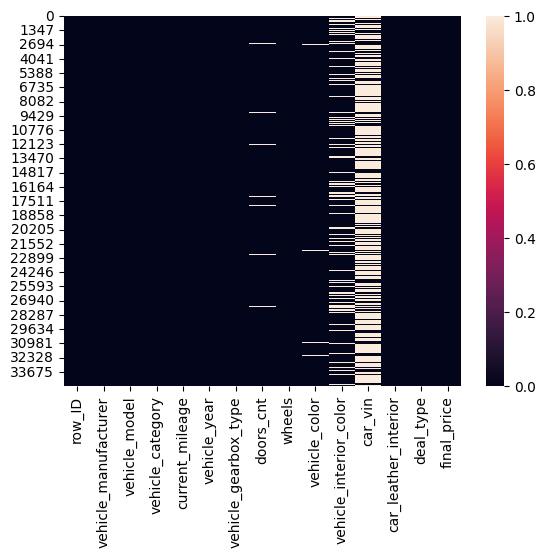

In [10]:
sns.heatmap(train_df.isnull());

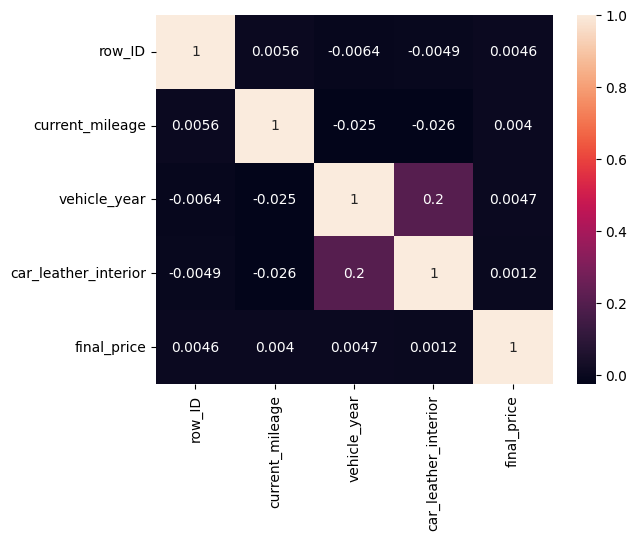

In [11]:
sns.heatmap(train_df.corr(), annot=True);

In [12]:
train_df.deal_type.value_counts()

For Sale    34372
For Rent      628
Name: deal_type, dtype: int64

In [21]:
tmp_df = train_df[train_df.final_price <= 1]
print(tmp_df.shape[0])
tmp_df.deal_type.value_counts()

30


For Sale    27
For Rent     3
Name: deal_type, dtype: int64

In [19]:
tmp_df = train_df[train_df.final_price >= 100_000]
tmp_df.shape[0]

9

Text(0, 0.5, 'Counts')

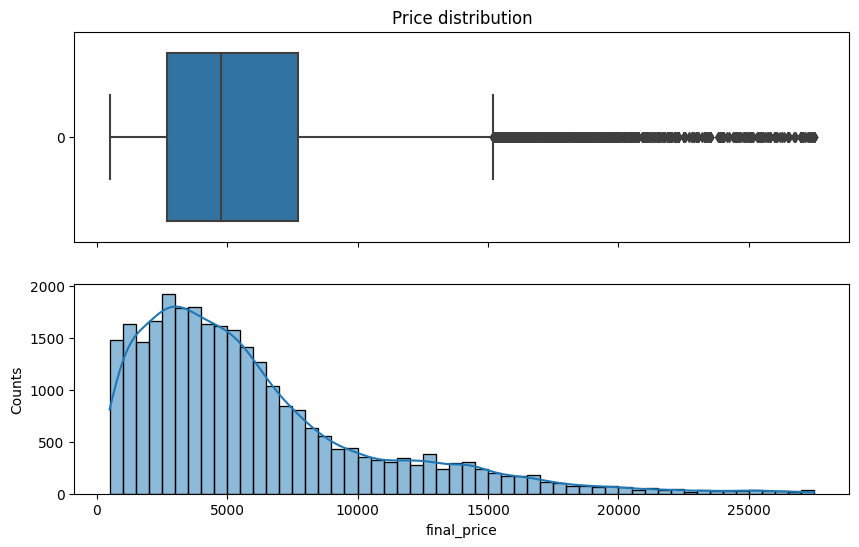

In [90]:
smart_df = train_df[(train_df.final_price <= 27500) & (train_df.final_price >= 500)]

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)
sns.boxplot(
    data=smart_df.final_price,
    orient='h',
    ax=axes[0]
)
sns.histplot(
    data=smart_df.final_price,
    kde=True,
    bins=54,
    ax=axes[1]
)
axes[0].set_title('Price distribution')
axes[1].set_ylabel('Counts')

## Feature Engineering ##

In [22]:
train_df = train_df[(train_df.final_price <= 100_000) & (train_df.final_price >= 1)]

## Продолжение ##

In [23]:
training_set, validation_set = train_test_split(
    train_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

In [24]:
task = Task('reg', loss='mae', metric='mae')
roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID']
}

In [25]:
automl = TabularAutoML(
    task=task,
    timeout=TIMEOUT,
    cpu_limit=N_THREADS,
    reader_params={'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [26]:
oof_pred = automl.fit_predict(
    training_set,
    roles=roles,
    verbose=0
)

c:\Programs\Python39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
c:\Programs\Python39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
c:\Programs\Python39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cnts = cnts.append(Series([cnts.shape[0] + 1], index=[np.nan]))
c:\Programs\Python39\lib\site-packages\lightautoml\transformers\categorical.py:1029: FutureWarning: The series.append method is deprecated and wi

In [27]:
print(automl.create_model_str_desc())

Final prediction for new objects (level 0) = 
	 0.92293 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
	 0.07707 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


In [28]:
val_pred = automl.predict(validation_set)
print(f'Prediction for the validation_set:\n{val_pred}\nShape = {val_pred.shape}')

Prediction for the validation_set:
array([[ 6065.75   ],
       [11733.257  ],
       [ 4394.746  ],
       ...,
       [12518.311  ],
       [  472.26532],
       [12345.63   ]], dtype=float32)
Shape = (6998, 1)


In [29]:
print(f'TRAIN out-of-fold score: {mean_absolute_error(training_set[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(validation_set[TARGET_NAME].values, val_pred.data[:, 0])}')

TRAIN out-of-fold score: 1589.3543140829013
HOLDOUT score: 1453.8981607445105


## Подготовка к Submission ##

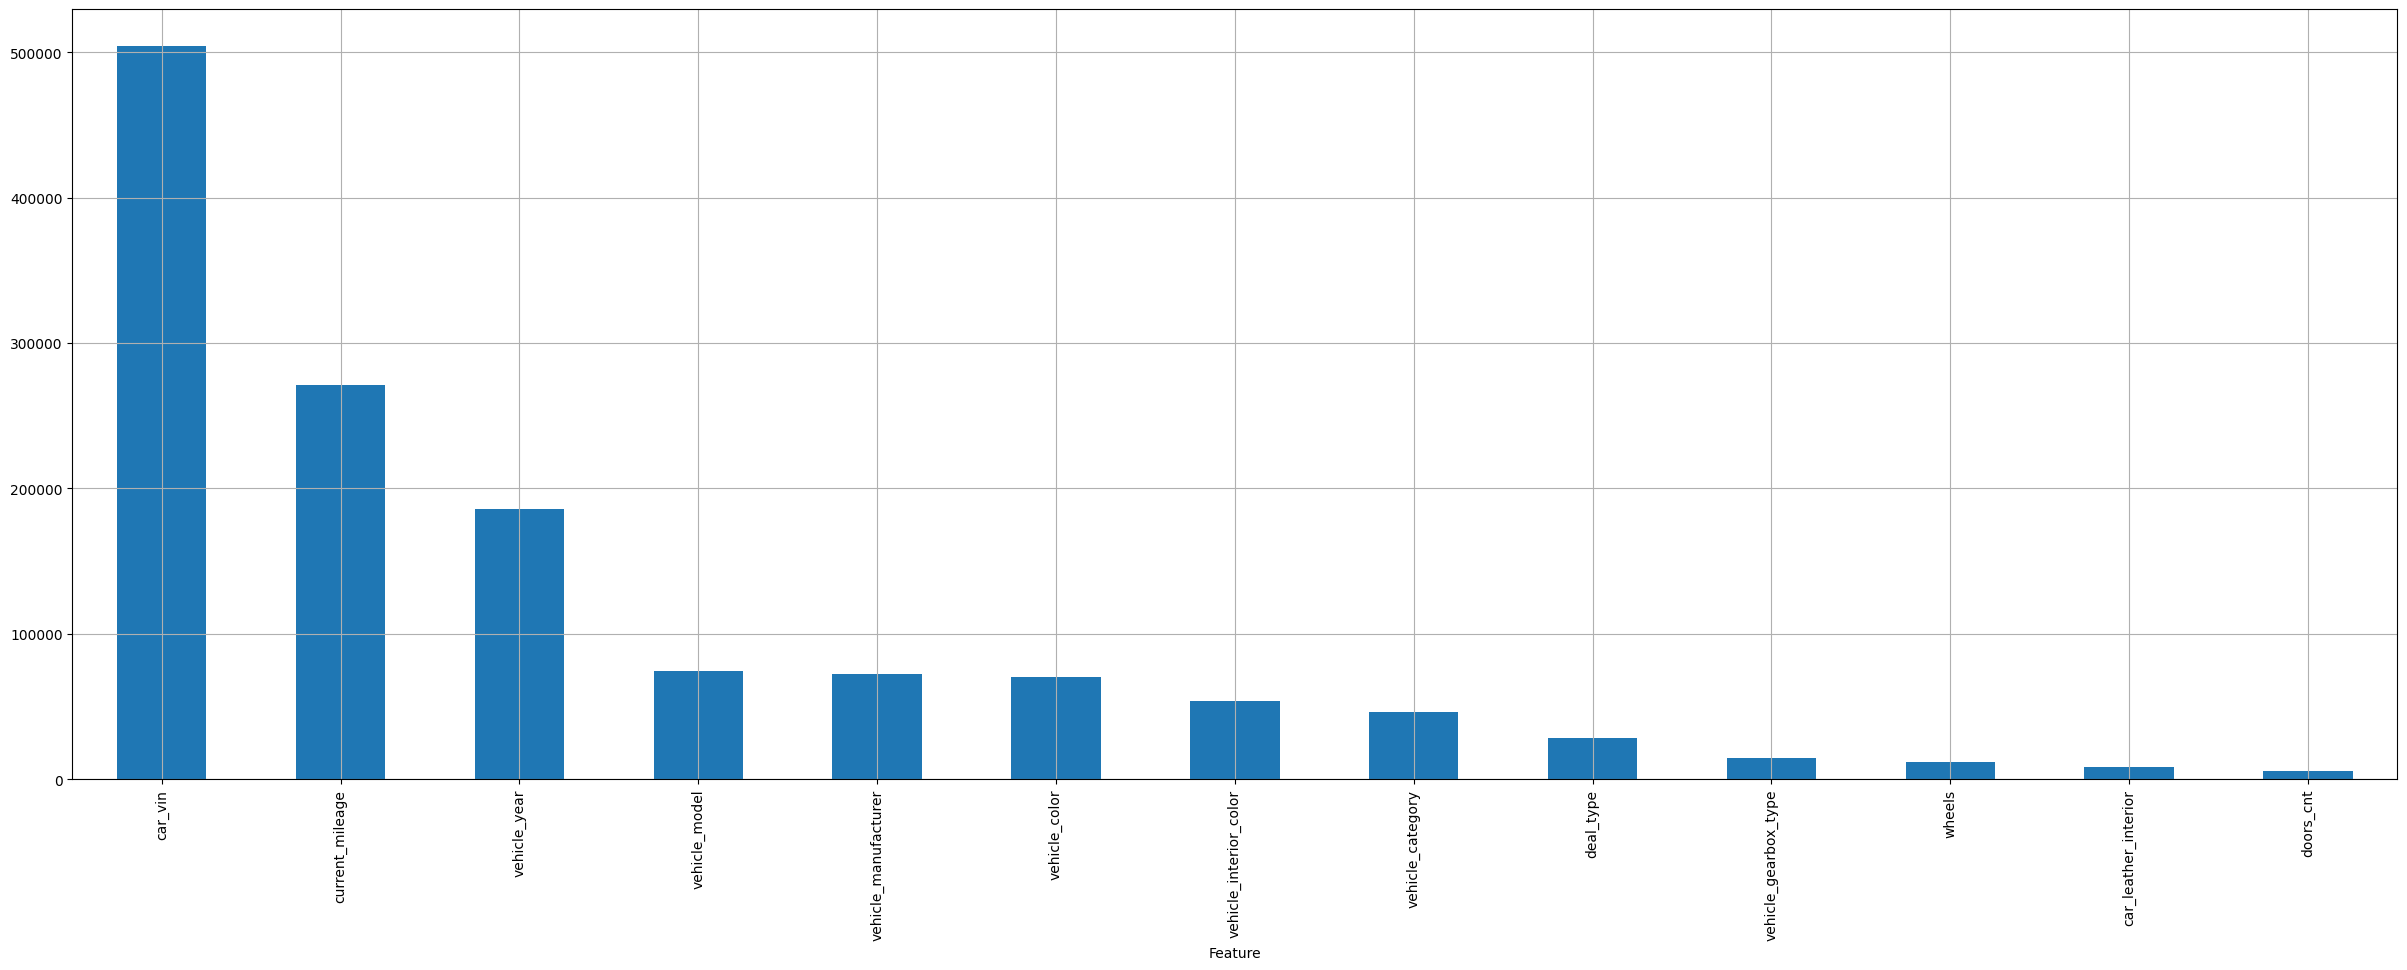

In [30]:
# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid=True);

In [31]:
# Accurate feature importances calculation (Permutation importances) -  
# can take long time to calculate on bigger datasets
accurate_fi = automl.get_feature_scores('accurate', validation_set, silent=False)

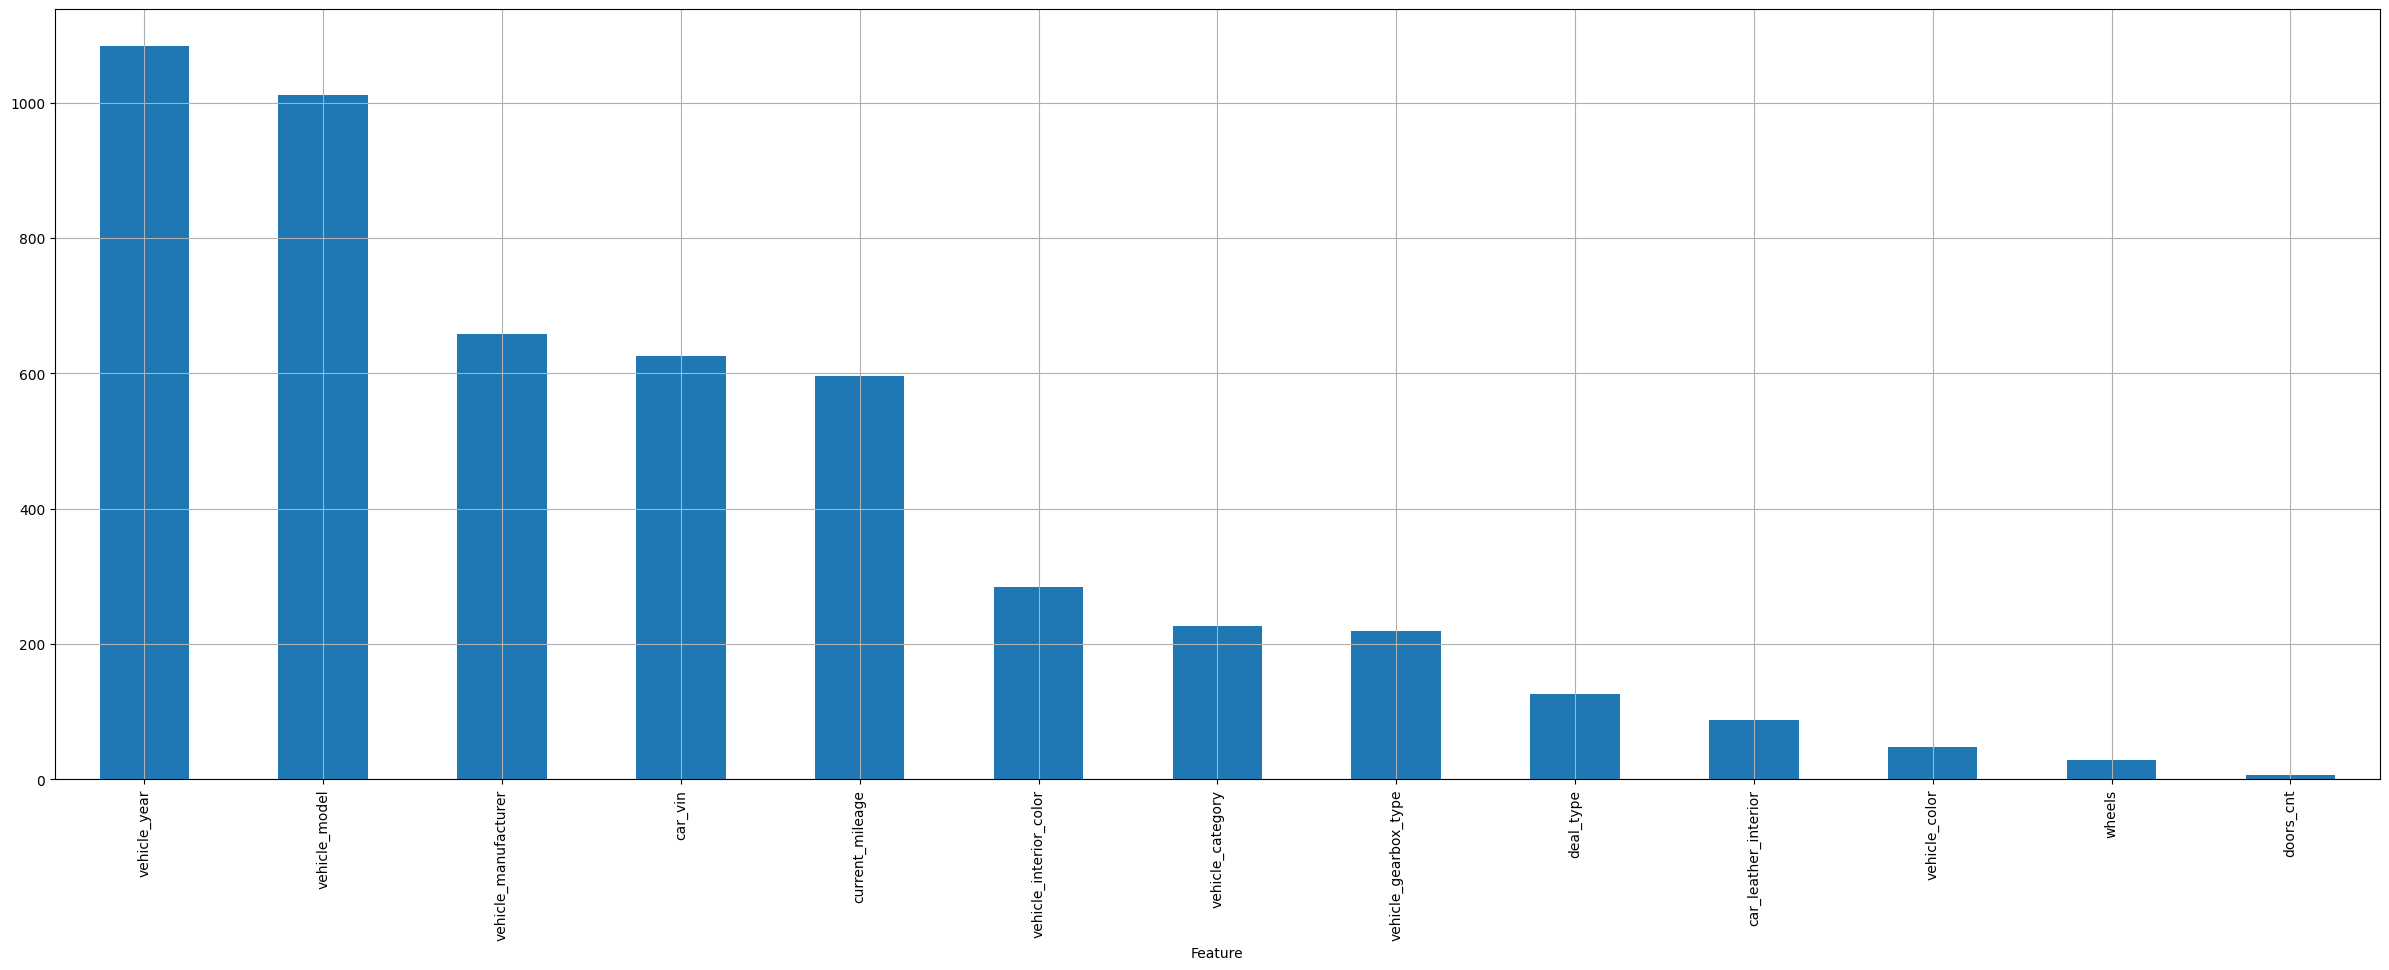

In [32]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize=(30, 10), grid=True);

## Выдача файла предсказаний ##

In [33]:
test_pred = automl.predict(test_df)
print(f'Prediction for the test dataframe:\n{test_pred}\nShape: {test_pred.shape}')

Prediction for the test dataframe:
array([[ 2815.252 ],
       [ 5527.6006],
       [ 3703.0044],
       ...,
       [17797.273 ],
       [ 5001.6055],
       [ 6504.0884]], dtype=float32)
Shape: (10697, 1)


In [34]:
sample_df[TARGET_NAME] = test_pred.data[:, 0]
sample_df.to_csv('output/sample_submission.csv', index=False)